# **A.TEXT PREPROCESSING & MODELING**

## **A.1.IMPORT DATA AND LIBRARIES** 

In [1]:
# Récupérer les données 
!gdown --id 1QS4KxTpqnwEJT3EisRh89Hg1AFgcJlhY
!unzip -qq challengeSIDM2-movies.min30.withtext.zip

#Importer les librairies 
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk
import scipy
from itertools import compress, product
from google.colab import files

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error



Downloading...
From: https://drive.google.com/uc?id=1QS4KxTpqnwEJT3EisRh89Hg1AFgcJlhY
To: /content/challengeSIDM2-movies.min30.withtext.zip
100% 18.1M/18.1M [00:00<00:00, 18.8MB/s]
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df = pd.read_csv('challengeSIDM2-movies.min30.withtext.csv')

## **A.2.TEXT DATA CLEANING**

In [3]:
########################################
#Replace NaN 
########################################

df = df.replace(np.nan, 'no data')
########################################
#Remove punctuation 
########################################

def remove_punctuation(x):  
    try:
        x = x.str.replace('[^\w\s]',' ')
    except:
        pass
    return x
df=df.apply(remove_punctuation)


########################################
#Put in lower case 
########################################
df = df.applymap(lambda s: s.lower() if type(s) == str else s)


########################################
#Remove stopwords
########################################
import nltk
nltk.download('stopwords')
stop = stopwords.words('english')
df['tag']= df['tag'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['title']= df['title'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['genres']= df['genres'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['plot']= df['plot'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
df['synopsis']= df['synopsis'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))


########################################
#Stem Lemma
########################################

from nltk.stem.porter import *
stemmer = PorterStemmer()

df['stem_tag']= df['tag'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
df['stem_title']= df['title'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
df['stem_genres']= df['genres'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
df['stem_plot']= df['plot'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
df['stem_synopsis']= df['synopsis'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))

# import timeit
# start = timeit.default_timer()
del df['youtubeId']
del df['tmdbId']
del df['imdbId']
del df['title_other']
# end = timeit.default_timer()
# print(end-start)

#########################################################################
# Enrichir le dataframe avec 2 variables à partir de de la colonne 'title'
#########################################################################

#2 nouvelles vars : new_title et movieYEAR
df['movieYEAR']=df.apply(lambda row : int(row.title[-4:]), axis=1)
df['new_title']=df.apply(lambda row : row.title[:-4], axis=1)


#4 classes: 4 quartiles
df['mYEAR_CLASS']= pd.qcut(df['movieYEAR'],q = 4, labels = False)
df['m_y_status']=df.apply(lambda row :0, axis=1)
df.loc[df['mYEAR_CLASS'] == 0, 'm_y_status'] = 'very old'
df.loc[df['mYEAR_CLASS'] == 1, 'm_y_status'] = 'old'
df.loc[df['mYEAR_CLASS'] == 2, 'm_y_status'] = 'recent'
df.loc[df['mYEAR_CLASS'] == 3, 'm_y_status'] = 'very recent'

#stem
df['stem_new_title']= df['new_title'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
df['stem_year_status']= df['m_y_status'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **A.3.SPLIT TRAIN & TEST**

In [4]:
 
# Ne pas changer pour garantir qu'on utilise tous les mêmes ensembles (train et test)
train_df = df.sample(frac=0.90, random_state=17)
train_df = df[df['movieId'].isin(train_df['movieId'])]
print("La taille de la collection d'entraînement est de",len(train_df),"films")
test_df = df[~df['movieId'].isin(train_df['movieId'])]
print("La taille de la collection de test est de",len(test_df),"films")

La taille de la collection d'entraînement est de 7087 films
La taille de la collection de test est de 787 films


In [5]:

#######################################################################################
#  train_df_stem : données ont subi porter-stem retraitemnt 
#######################################################################################

train_df_stem=train_df[['movieId', 'rating','stem_tag', 'stem_genres', 'stem_plot','stem_year_status']]
test_df_stem=test_df[['movieId', 'rating','stem_tag', 'stem_genres', 'stem_plot','stem_year_status']]

## **A.4.EVALUATION D'UNE METHODE DE REPRESENTATION**

In [ ]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

### **BERT MiniLM-L6-V2**

In [48]:
# BERT avec pre entrainement 'paraphrase-MiniLM-L6-v2'
sbert_model_train = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [49]:
#IMPORTANT :
train_df.index=range(train_df.shape[0])
test_df.index=range(test_df.shape[0])

In [ ]:
# BERT -MiniLM-L6-v2 REFERENCE INDICATORS 
tr_sentences_genres=train_df['stem_genres']
TR_BERTL6V2_genres= sbert_model_train.encode(tr_sentences_genres)

ts_sentences_genres=test_df['stem_genres']
TS_BERTL6V2_genres= sbert_model_train.encode(ts_sentences_genres)

reg = LinearRegression().fit(TR_BERTL6V2_genres, train_df['rating'])
pred = reg.predict(TS_BERTL6V2_genres)
mean_squared_error(pred,test_df['rating'])

0.22364832746168117

##### **Evaluationd de correlation plot et synopsis**

In [58]:
ts_sentences_syn=test_df['stem_synopsis']
TS_BERTL6V2_SYN= sbert_model_train.encode(ts_sentences_syn)

In [59]:
ts_sentences_plot=test_df['stem_plot']
TS_BERTL6V2_PLOT= sbert_model_train.encode(ts_sentences_plot)

In [64]:
from scipy.stats import pearsonr
corr, _ = pearsonr(TS_BERTL6V2_SYN.flatten(),TS_BERTL6V2_PLOT.flatten())
print(corr)

0.25161726965856035


In [67]:
np.corrcoef(TS_BERTL6V2_SYN.flatten(),TS_BERTL6V2_PLOT.flatten())

array([[1.        , 0.25161727],
       [0.25161727, 1.        ]])

### **BERT bert-base-nli-mean-token**

In [ ]:
# BERT avec pre entrainement ''bert-base-nli-mean-tokens''
sbert_model_train = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#IMPORTANT :
train_df.index=range(train_df.shape[0])
test_df.index=range(test_df.shape[0])

In [ ]:
# Evaluating BERT bert-base-nli-mean-tokens 
tr_sentences_genres=train_df['stem_genres']
TR_BERTL6V2_genres= sbert_model_train.encode(tr_sentences_genres)

ts_sentences_genres=test_df['stem_genres']
TS_BERT_Lnli_genres= sbert_model_train.encode(ts_sentences_genres)

reg = LinearRegression().fit(TR_BERTL6V2_genres, train_df['rating'])
pred = reg.predict(TS_BERT_Lnli_genres)
mean_squared_error(pred,test_df['rating'])

2.956976475637775

### **BERT roberta base v1**

In [ ]:
# BERT avec pre entrainement 'distilroberta-base-v1')

sbert_model_train = SentenceTransformer('paraphrase-distilroberta-base-v1')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/718 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#IMPORTANT :
train_df.index=range(train_df.shape[0])
test_df.index=range(test_df.shape[0])

In [ ]:
# Evaluating BERT RE
tr_sentences_genres=train_df['stem_genres']
TR_BERTL6V2_genres= sbert_model_train.encode(tr_sentences_genres)

ts_sentences_genres=test_df['stem_genres']
TS_BERT_roberta_genres= sbert_model_train.encode(ts_sentences_genres)

reg = LinearRegression().fit(TR_BERTL6V2_genres, train_df['rating'])
pred = reg.predict(TS_BERT_roberta_genres)
mean_squared_error(pred,test_df['rating'])

34.619389464970745

### **TFIDF**

In [ ]:
# TFIDF REFERENCE INDICATORS 
vectorizer = TfidfVectorizer(min_df=50)
tfidf = vectorizer.fit_transform(train_df['genres'])
reg = LinearRegression().fit(tfidf, train_df['rating'])
pred = reg.predict(vectorizer.transform(test_df['genres']))
mean_squared_error(pred,test_df['rating'])

0.19454105053364473

### **TFIDF vs BERT**

In [ ]:
#Build a visualization for comparison
keys_list = ['TFIDF','BERT_l6v2','BERT_nli_mean','BERT_roberta_V1']
values_list = ['0.19454105053364473','0.22364832746168117','2.956976475637775','34.619389464970745']
zip_iterator = zip(keys_list, values_list)
a_dictionary = dict(zip_iterator)

df_rep_comp=pd.DataFrame(list(a_dictionary.items()),columns=['Representation_technique', 'MSE_COMPARISON_MODEL'])
df_rep_comp

#POUR RAPPEL :naive baseline (il n'y pas d'apprentissage ni de représentation) = 0.2726773158525839
#mean_squared_error([np.mean(train_df['rating'])]*len(test_df),test_df['rating'])


,Representation_technique,MSE_COMPARISON_MODEL
0,TFIDF,0.19454105053364473
1,BERT_l6v2,0.22364832746168117
2,BERT_nli_mean,2.956976475637775
3,BERT_roberta_V1,34.619389464970745


In [20]:
# # Evaluer les corrélations entre vecteurs texte:plot et synopsis
# vectorizer_syn = TfidfVectorizer(min_df=50)
# df['vec_syn']=vectorizer_syn.fit_transform(df['synopsis'])
#np.coercoff


In [14]:
# vectorizer_plot = TfidfVectorizer(min_df=50)
# df['vec_pl']=vectorizer_plot.fit_transform(df['plot'])

In [46]:
# df['vec_pl'].values.shape


## **A.5. TEXT MODELING**

### **5.1.SCALABLE FUNCTION FOR MODELING & FEATURE SELECTION**

In [ ]:
##############################################################################
# MSE SCORE COMPUTER
###############################################################################
#model :type de model (linear regression, svr , xgboost) 
#cols_X:Variables explicatives
#col_y:variable à prédire
#train_df:dataframe train choisie
#test_df:dataframe test choisie
def score_computer(model,cols_X,col_y,train_df,test_df):
    from itertools import compress, product

    def combinations(items):
        return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )
        # alternative:                      ...in product([0,1], repeat=len(items)) 
        
    comb={}
    for i, item in enumerate(list(combinations(cols_X))[1:]):
      comb['config_'+str(i)]=list(item)
    comb

    score=[]
    for config in comb.keys():
      
      lst_train=[]
      lst_test=[]
      for col in comb[config]:
        vectorizer = TfidfVectorizer(min_df=50)
        vec_tr=vectorizer.fit_transform(train_df[col])
        lst_train.append(vec_tr)
        lst_test.append(vectorizer.transform(test_df[col]))
      
      if len(lst_train)==1:     
        train=lst_train[0]
        test=lst_test[0]
      else:
        train=scipy.sparse.hstack(lst_train, format=None, dtype=None)
        test=scipy.sparse.hstack(lst_test, format=None, dtype=None)                 
      
      reg = model.fit(train,np.asarray(train_df[col_y]).ravel())

      pred = reg.predict(test)
      score.append((config, mean_squared_error(pred,test_df[col_y])))
    dict(score)
    

    return dict(score)

##############################################################################
# LABEL BUILDER
###############################################################################
def labels(predictors):
  from itertools import compress, product

  def combinations(items):
      return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )
      # alternative:                      ...in product([0,1], repeat=len(items)) 
      
  comb={}
  for i, item in enumerate(list(combinations(predictors))[1:]):
    comb['config_'+str(i)]=list(item)
  return comb


###############################################################################
# SCORE DATAFRAMER
###############################################################################
#mise en forme des résultats pour une meilleure visualisation
def score_dframer(model,predictors,predicted):
  df_MSE=pd.DataFrame(list(score_computer(model,predictors,predicted,train_df_stem,test_df_stem).items()),columns=['Configurations', 'MSE'])
  df_LABELS=pd.DataFrame(list(labels(predictors).items()),columns=['Configurations', 'Labels'])
  df_merg = pd.merge(df_MSE, df_LABELS, how='inner')
  df_merg.sort_values(by=['MSE'], inplace=True, ascending=True)
  df_merg['n_conf']=[w.split("_")[-1] for w in df_merg['Configurations']]
  print('STATISTICS OF MSE INDICATOR AND OUTPUT:')
  print(df_merg.describe())
  sns.barplot(x="n_conf", y="MSE", data=df_merg)
  #df_merg.to_csv('text_newtitle_RFOREST_MSE.csv')
  return df_merg

###############################################################################
# EXAMPLES OF PREDICTOR INPUT COMBINATIONS
###############################################################################

#BASELINE
#predictors=['stem_genres']

#ALL
#predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']

#MOST PERFORMING (with SVR)
#predictors=['stem_tag','stem_year_status','stem_genres','stem_plot'] 


### **5.2.MODELING WITH LINEAR REGRESSION**

STATISTICS OF MSE INDICATOR AND OUTPUT:
             MSE
count  15.000000
mean    0.191274
std     0.048972
min     0.114012
25%     0.158422
50%     0.193608
75%     0.227589
max     0.265620


,Configurations,MSE,Labels,n_conf
13,config_13,0.114012,"[stem_tag, stem_year_status, stem_genres]",13
9,config_9,0.117261,"[stem_tag, stem_genres]",9
11,config_11,0.141206,"[stem_tag, stem_year_status]",11
7,config_7,0.142719,[stem_tag],7
14,config_14,0.174126,"[stem_tag, stem_year_status, stem_plot, stem_g...",14
10,config_10,0.178851,"[stem_tag, stem_plot, stem_genres]",10
5,config_5,0.182030,"[stem_genres, stem_year_status]",5
12,config_12,0.193608,"[stem_tag, stem_year_status, stem_plot]",12
1,config_1,0.194541,[stem_genres],1
8,config_8,0.197165,"[stem_tag, stem_plot]",8


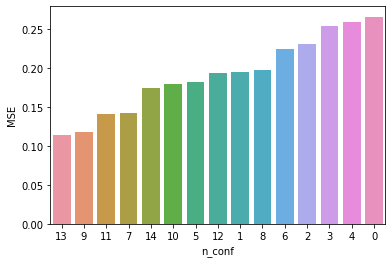

In [ ]:

###############################################################################
# SET PAARAMETERS
###############################################################################
predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
predicted=['rating']
model=LinearRegression()

###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
score_dframer(model,predictors,predicted)



### **5.3.MODELING WITH SVR**

STATISTICS OF MSE INDICATOR AND OUTPUT:
             MSE
count  15.000000
mean    0.151260
std     0.045551
min     0.099036
25%     0.115673
50%     0.137516
75%     0.184943
max     0.261146


,Configurations,MSE,Labels,n_conf
14,config_14,0.099036,"[stem_tag, stem_year_status, stem_plot, stem_g...",14
10,config_10,0.104304,"[stem_tag, stem_plot, stem_genres]",10
13,config_13,0.104696,"[stem_tag, stem_year_status, stem_genres]",13
9,config_9,0.108732,"[stem_tag, stem_genres]",9
12,config_12,0.122614,"[stem_tag, stem_year_status, stem_plot]",12
8,config_8,0.125756,"[stem_tag, stem_plot]",8
7,config_7,0.135941,[stem_tag],7
11,config_11,0.137516,"[stem_tag, stem_year_status]",11
6,config_6,0.151862,"[stem_genres, stem_year_status, stem_plot]",6
2,config_2,0.158151,"[stem_genres, stem_plot]",2


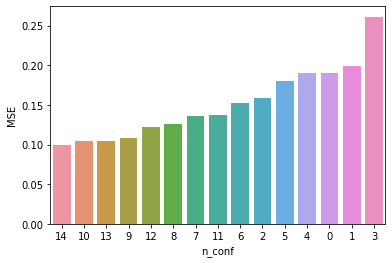

In [ ]:
###############################################################################
# SET PAARAMETERS
###############################################################################
predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
predicted=['rating']
model=SVR(kernel='rbf')

###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
score_dframer(model,predictors,predicted)


#### **OPTIMISATION DES RESULTATS**

In [ ]:
#TO DO :


### **5.4.MODELING WITH XGBOOST**

STATISTICS OF MSE INDICATOR AND OUTPUT:
             MSE
count  15.000000
mean    0.156806
std     0.040625
min     0.109689
25%     0.125745
50%     0.148129
75%     0.185566
max     0.253727


,Configurations,MSE,Labels,n_conf
13,config_13,0.109689,"[stem_year_status, stem_genres, stem_tag]",13
14,config_14,0.109712,"[stem_year_status, stem_genres, stem_tag, stem_plot]",14
10,config_10,0.113524,"[stem_genres, stem_tag, stem_plot]",10
9,config_9,0.115291,"[stem_genres, stem_tag]",9
12,config_12,0.136200,"[stem_year_status, stem_tag, stem_plot]",12
8,config_8,0.139179,"[stem_tag, stem_plot]",8
11,config_11,0.143683,"[stem_year_status, stem_tag]",11
7,config_7,0.148129,[stem_tag],7
6,config_6,0.159574,"[stem_year_status, stem_genres, stem_plot]",6
2,config_2,0.162024,"[stem_genres, stem_plot]",2


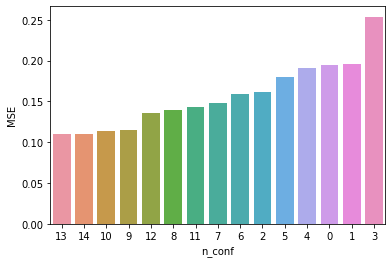

In [ ]:
###############################################################################
# SET PAARAMETERS
###############################################################################
predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
predicted=['rating']
model=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)


###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
score_dframer(model,predictors,predicted)

In [ ]:
#optimisation
model.get_params()

{'alpha': 10,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 10,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
colsample_bytree = [0.3, 0.5, 1.0]
gamma = [0.1, 1, 1.5]
learning_rate = [0.001, 0.01]
min_child_weight = [1, 5, 10]
scale_pos_weight = [1, 2, 4]
subsample = [0.8, 0.9, 1.0]
n_estimators = [50, 100, 150]
max_depth = [5, 10]

param_grid = dict(
    colsample_bytree=colsample_bytree,
    gamma=gamma,
    learning_rate=learning_rate,
    min_child_weight=min_child_weight,
    scale_pos_weight=scale_pos_weight,
    subsample=subsample,
    n_estimators=n_estimators,
    max_depth=max_depth,
)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            )
# best_model = grid_search.fit(train_df_text['stem_tag'], train_df_text['rating'])
# print('Optimum parameters', best_model.best_params_)

# **B.EARLY INTEGRATION TEXT WITH AUDIO**

### **B.1.1.IMPORT AUDIO DATAFRAME & PREPARE FOR MERGING**

In [ ]:
#########################################################
# Reprise dataframe text pour Intégration Text-Audio-Image
#########################################################

#visualize text dataframe
df_text=df
df_text.head(5)
##############################################################
# Keep only auditext identified as best in previous work
##############################################################
important_cols_text = ['rating','movieId','stem_tag','stem_genres','stem_plot','stem_year_status']
for col in df_text.columns:
  if col not in important_cols_text:
    del df_text[col]

print("shape de datframe text :",df_text.shape)


shape de datframe text : (7874, 6)


In [ ]:
#####################################################
# Import dataframe audio 
#####################################################
df_audio=pd.read_csv('/content/Copy of df_audio.csv')
df_audio.rename(columns = {'id':'movieId'}, inplace = True)

##############################################################
# Keep only audio features identified as best in previous work
##############################################################
important_cols_audio = ['rating','movieId','duree','rolloff','mfcc1','mfcc3']
for col in df_audio.columns:
  if col not in important_cols_audio:
    del df_audio[col]

#Visualiser df_audio
df_audio.shape

(7797, 6)

### **B.1.2.MERGE TEXT AND AUDIO DATAFRAME**

In [ ]:
#####################################################
# MERGE AUDIO & TEXT
#####################################################
df_MERGE_T_A = pd.merge(df_text, df_audio, how='inner')
print("shape de merged dataframe :",df_MERGE_T_A.shape)
df_MERGE_T_A.head(5)

shape de merged dataframe : (6895, 10)


,movieId,rating,stem_tag,stem_genres,stem_plot,stem_year_status,duree,rolloff,mfcc1,mfcc3
0,3,3.151040,old peopl actual funni sequel fever grun run moldi old comedinha de velhinho engraãƒâ ada funniest movi sequel jack lemmon walter matthau no_fa_gan howard deutch sequel comedinha de velhinho engraã ada moldi old clv comedi,comedi romanc,john max resolv save belov bait shop turn italian restaur new femal owner catch max attent mystic80 thing seem chang much wabasha counti max john still fight 35 year grandpa still drink smoke chase women nobodi abl catch fabl catfish hunter gigant catfish actual smile fishermen tri snare six month ago john marri new girl town ariel peopl begin suspect max might miss someth similar life joy max claim left life fish might chang new owner bait shop murray chapman muzzl cs uq oz au,old,111.920250,6852.587933,-228.152084,-28.875706
1,7,3.366484,greg kinnear romanc remadea sabrina 1995 remakeof sabrina 1954 upstair downstair base play chick flick find greg kinnear harrison ford pari remak ugli duckl chick flick remak drama find great cast greg kinnear julia ormond love stori remak romanc romanc chick flick remak remak no_fa_gan base play chick flick harrison ford julia ormond nanci marchand remak base play remak remak great cast harrison ford romanc harrison ford relationship clv greg kinnear remak,comedi romanc,ugli duckl undergon remark chang still harbor feel crush carefre playboy busi focus brother someth say monkeykingma grow sabrina fairchild spent time perch tree watch larrabe famili ever solid ground chauffeur daughter lavish long island estat sabrina invis behind branch knew maud larrabe modern matriarch larrabe corpor linu larrabe seriou older son expand success famili busi world largest commun compani david handsom fun love larrabe center sabrina world ship pari two year staff vogu magazin sabrina return larrabe estat blossom beauti sophist woman stand way billion dollar deal cyril morcrett cyril cln46fw der edf fr larrabe wealthi famili live palati estat long island oldest brother linu play harrison ford formal dour businessman run famili compani david greg kinnear playboy among staff live estat famili chauffeur fairchild john wood shi awkward plain daughter sabrina julia ormond sabrina crush david life hardli notic sabrina goe studi pari come back two year later chang woman sophist beauti soon catch david eye howev david engag elizabeth tyson lauren holli daughter busi mogul whose compani linu want merg larrabe sabrina wreck david elizabeth relationship would like spell end busi merger linu set prevent sabrina get way process fall grantss sabrina fairchild daughter larrabe famili chauffeur larrabe wealthi promin long island famili maud mother linu elder brother took charg compani father die devot entir life compani david younger brother work day life numer girlfriend sabrina nonetheless enamor david think frumpi daughter chauffeur maud arrang go pari work vogu sabrina fascin david grow david meantim meet elizabeth tyson tell linu maud could one know first linu want go busi parent encourag relationship david find furiou linu tell time contribut someth deal tyson worth billion dollar david somehow propos accept long sabrina return david recogn first littl differ david also entranc linu maud concern deal jeopardi elizabeth parent find pursuit sabrina david injur linu tri distract sabrina linu find feel thing felt year rcs0411 yahoo com,old,169.482500,5404.350321,-265.355255,-27.417568
2,11,3.667713,presid presid us presid white hous girli movi clever dialogu polit amaz kung fu decent flick annett bene ethic great cast great perform great stori michael dougla moral drama romanc cute seen dvd collect screenwrit aaron sorkin no_fa_gan rob reiner aaron sorkin clever dialogu cute girli movi great perform martin sheen michael dougla polit rob reiner romanc polit singl parent us presid polit presid aaron sorkin michael dougla polit clv aaron sorkin 23 03 06 bibliothek seen romanc,comedi drama rom

### **B.1.3.SPLIT TRAIN TEST**

In [ ]:
#####################################################
# TRain Test split dataframe df_MERGE_T_A
#####################################################
# Ne pas changer pour garantir qu'on utilise tous les mêmes ensembles (train et test)
train_df_MERGE_T_A = df_MERGE_T_A.sample(frac=0.90, random_state=17)
train_df_MERGE_T_A = df_MERGE_T_A[df_MERGE_T_A['movieId'].isin(train_df_MERGE_T_A['movieId'])]
print("La taille de la collection d'entraînement est de",len(train_df_MERGE_T_A),"films")
test_df_MERGE_T_A = df_MERGE_T_A[~df_MERGE_T_A['movieId'].isin(train_df_MERGE_T_A['movieId'])]
print("La taille de la collection de test est de",len(test_df_MERGE_T_A),"films")


La taille de la collection d'entraînement est de 6206 films
La taille de la collection de test est de 689 films


### **B.1.4.COMPUTE SCORES**

#### **GENERIC INTEGRATED FUNCTION MSE COMPUTER** 

In [ ]:
##############################################
#FONCTION DE CALCUL DE SCORE MSE
#############################################

def final_score_computer(model,cols_X,col_y,train_df,test_df):
    text_cols=['stem_tag','stem_genres','stem_plot','stem_year_status']
    from itertools import compress, product

    def combinations(items):
        return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )
        # alternative:                      ...in product([0,1], repeat=len(items)) 
        
    comb={}
    for i, item in enumerate(list(combinations(cols_X))[1:]):
      comb['config_'+str(i)]=list(item)
    comb

    score=[]
    for config in comb.keys():
      
      lst_train=[]
      lst_test=[]
      for col in comb[config]:
        if col in text_cols:
          vectorizer = TfidfVectorizer(min_df=50)
          vec_tr=vectorizer.fit_transform(train_df[col])
          lst_train.append(vec_tr.todense())
          lst_test.append(vectorizer.transform(test_df[col]).todense())
        else:
          
          lst_train.append(np.array(train_df[col].values).reshape(-1,1))          
          lst_test.append(np.array(test_df[col].values).reshape(-1,1))
      
      if len(lst_train)==1:         
        train=lst_train[0]
        test=lst_test[0]
      else:
        train=np.hstack(lst_train)
        test=np.hstack(lst_test)                 
      
      reg = model.fit(train,np.asarray(train_df[col_y]).ravel())

      pred = reg.predict(test)
      score.append((config, mean_squared_error(pred,test_df[col_y])))
    dict(score)
    

    return dict(score)

##############################################################################
# LABEL BUILDER
###############################################################################
def labels(cols_X):
  from itertools import compress, product

  def combinations(items):
      return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )
      # alternative:                      ...in product([0,1], repeat=len(items)) 
      
  comb={}
  for i, item in enumerate(list(combinations(cols_X))[1:]):
    comb['config_'+str(i)]=list(item)
  return comb

def final_score_dframer(model,cols_X,col_y,train_df,test_df):
  pd.set_option('display.max_colwidth', None)
  df_MSE=pd.DataFrame(list(final_score_computer(model,cols_X,col_y,train_df,test_df).items()),columns=['Configurations', 'MSE'])
  df_LABELS=pd.DataFrame(list(labels(cols_X).items()),columns=['Configurations', 'Labels'])
  df_merg = pd.merge(df_MSE, df_LABELS, how='inner')
  df_merg.sort_values(by=['MSE'], inplace=True, ascending=True)
  df_merg['n_conf']=[w.split("_")[-1] for w in df_merg['Configurations']]
  print('STATISTICS OF MSE INDICATOR AND OUTPUT:')
  print(df_merg.describe())
  sns.barplot(x="n_conf", y="MSE", data=df_merg)
  #df_merg.to_csv('text_newtitle_RFOREST_MSE.csv')
  return df_merg

#### **B.1.1.1.TEXT_AUDIO INTEGRATED MODELING WITH LINEAR REGRESSION**

STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.166473
std      0.049117
min      0.112231
25%      0.121502
50%      0.129789
75%      0.197774
max      0.245965


,Configurations,MSE,Labels,n_conf
117,config_117,0.112231,"[stem_genres, stem_year_status, mfcc1, stem_tag, duree]",117
125,config_125,0.112327,"[stem_genres, stem_year_status, mfcc1, mfcc3, stem_tag, duree]",125
118,config_118,0.112387,"[stem_genres, stem_year_status, mfcc1, stem_tag, rolloff, duree]",118
126,config_126,0.112392,"[stem_genres, stem_year_status, mfcc1, mfcc3, stem_tag, rolloff, duree]",126
113,config_113,0.112436,"[stem_year_status, duree, stem_genres, stem_tag]",113
...,...,...,...,...
3,config_3,0.241583,[mfcc1],3
9,config_9,0.241815,"[duree, mfcc3]",9
7,config_7,0.242121,[mfcc3],7
0,config_0,0.242269,[rolloff],0


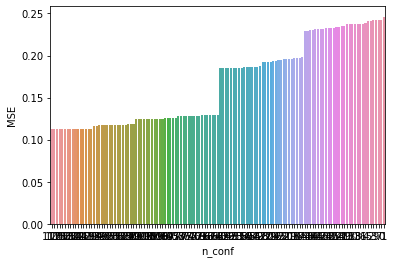

In [ ]:
##############################################
#APPEL DE FONCTION 'final_score_computer'  
#############################################

#Passer les paramètres
model=LinearRegression()
cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_A
test_df=test_df_MERGE_T_A

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)


In [ ]:
# Dataframe : uniquement pour visusalisation multi-modal
list_indices=['0.114012','0.217390','0.112231']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","AUDIO ONLY","TEXT & AUDIO"],columns=['Best_MSE_LINEAR_REGRESSION'])
df_integral_TA.sort_values(by=['Best_MSE_LINEAR_REGRESSION'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_LINEAR_REGRESSION
TEXT & AUDIO,0.112231
TEXT ONLY,0.114012
AUDIO ONLY,0.217390


#### **B.1.1.2.TEXT_AUDIO INTEGRATED MODELING WITH SVR**

STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.233970
std      0.024861
min      0.101306
25%      0.238466
50%      0.240240
75%      0.242945
max      0.245964


,Configurations,MSE,Labels,n_conf
111,config_111,0.101306,"[stem_year_status, stem_genres, stem_tag]",111
79,config_79,0.112966,"[stem_genres, stem_tag]",79
95,config_95,0.114447,"[stem_year_status, stem_tag]",95
63,config_63,0.123343,[stem_tag],63
119,config_119,0.176876,"[stem_year_status, stem_genres, stem_tag, mfcc3]",119
...,...,...,...,...
16,config_16,0.245068,"[stem_genres, rolloff]",16
3,config_3,0.245272,[mfcc1],3
1,config_1,0.245822,[duree],1
0,config_0,0.245838,[rolloff],0


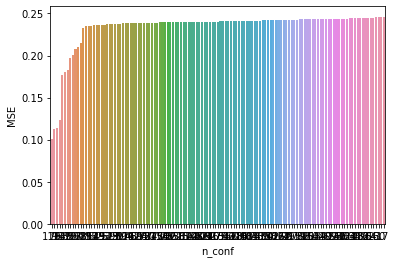

In [ ]:
#############################################
#APPEL DE FONCTION 'final_score_computer'
#############################################

#Passer les paramètres
model=SVR(kernel='rbf')
cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_A
test_df=test_df_MERGE_T_A

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

In [ ]:
# Dataframe : uniquement pour visusalisation multi-modal
list_indices=['0.104696',' 0.243119','0.101306']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","AUDIO ONLY","TEXT & AUDIO"],columns=['Best_MSE_SVR'])
df_integral_TA.sort_values(by=['Best_MSE_SVR'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_SVR
AUDIO ONLY,0.243119
TEXT & AUDIO,0.101306
TEXT ONLY,0.104696


#### **B.1.1.3TEXT_AUDIO INTEGRATED MODELING WITH XG BOOST**

STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.165268
std      0.049165
min      0.107569
25%      0.121256
50%      0.133740
75%      0.193185
max      0.249060


,Configurations,MSE,Labels,n_conf
117,config_117,0.107569,"[stem_genres, stem_year_status, mfcc1, stem_tag, duree]",117
113,config_113,0.107581,"[stem_year_status, duree, stem_genres, stem_tag]",113
116,config_116,0.108704,"[stem_genres, stem_year_status, mfcc1, stem_tag, rolloff]",116
120,config_120,0.108841,"[stem_genres, stem_year_status, mfcc3, stem_tag, rolloff]",120
121,config_121,0.108992,"[stem_genres, stem_year_status, mfcc3, stem_tag, duree]",121
...,...,...,...,...
0,config_0,0.243830,[rolloff],0
5,config_5,0.244902,"[duree, mfcc1]",5
9,config_9,0.246247,"[duree, mfcc3]",9
7,config_7,0.247379,[mfcc3],7


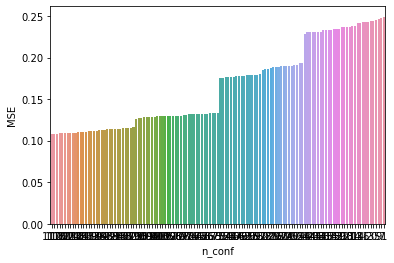

In [ ]:
#############################################
#APPEL DE FONCTION 'final_score_computer'
#############################################

#Passer les paramètres
model=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_A
test_df=test_df_MERGE_T_A

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

In [ ]:
# Dataframe : uniquement pour visusalisation multi-modal
list_indices=['0.109689','0.210611','0.107569']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","AUDIO ONLY","TEXT & AUDIO"],columns=['Best_MSE_XG_BOOST'])
df_integral_TA.sort_values(by=['Best_MSE_XG_BOOST'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_XG_BOOST
TEXT & AUDIO,0.107569
TEXT ONLY,0.109689
AUDIO ONLY,0.210611


# **C.EARLY INTEGRATION TEXT WITH IMAGE**

### **C.1.IMPORT IMAGE DATAFRAME**

In [ ]:

#####################################################
# Import dataframe audio 
#####################################################
df_image=pd.read_csv('/content/df_3kf_features.csv')
df_image.rename(columns = {'id':'movieId'}, inplace = True)

df_image.columns
# ##############################################################
# # Keep only audio features identified as best in previous work
# ##############################################################
important_cols_image = ['movieId','sharpnessframe1','contrastframe1','saturationframe1','brightnessframe1']
for col in df_image.columns:
  if col not in important_cols_image:
    del df_image[col]
    
df_image.shape


(7288, 5)

### **C.2.MERGE IMAGE AND TEXT**

In [ ]:
df_MERGE_T_I = pd.merge(df_text, df_image, how='inner')
print("shape de merged dataframe :",df_MERGE_T_I.shape)
df_MERGE_T_I.head(5)

shape de merged dataframe : (6565, 10)


,movieId,rating,stem_tag,stem_genres,stem_plot,stem_year_status,sharpnessframe1,contrastframe1,saturationframe1,brightnessframe1
0,1,3.921240,watch comput anim disney anim featur pixar ani...,adventur anim children comedi fantasi,cowboy doll profoundli threaten jealou new spa...,old,57.419495,54.635186,93.878275,41.419639
1,1,3.921240,watch comput anim disney anim featur pixar ani...,adventur anim children comedi fantasi,cowboy doll profoundli threaten jealou new spa...,old,73.768019,67.869164,111.341066,95.979946
2,1,3.921240,watch comput anim disney anim featur pixar ani...,adventur anim children comedi fantasi,cowboy doll profoundli threaten jealou new spa...,old,53.008070,49.664799,73.984704,65.782978
3,2,3.211977,time travel adapt book board game childhood re...,adventur children fantasi,two kid find play magic board game releas man ...,old,61.561568,60.243742,15.579384,20.313466
4,2,3.211977,time travel adapt book board game childhood re...,adventur children fantasi,two kid find play magic board game releas man ...,old,9.318242,8.849087,0.000000,42.010924


In [ ]:
df_MERGE_T_I=df_MERGE_T_I.drop_duplicates(subset=['movieId'],keep='first')
df_MERGE_T_I.head(5)

,movieId,rating,stem_tag,stem_genres,stem_plot,stem_year_status,sharpnessframe1,contrastframe1,saturationframe1,brightnessframe1
0,1,3.921240,watch comput anim disney anim featur pixar ani...,adventur anim children comedi fantasi,cowboy doll profoundli threaten jealou new spa...,old,57.419495,54.635186,93.878275,41.419639
3,2,3.211977,time travel adapt book board game childhood re...,adventur children fantasi,two kid find play magic board game releas man ...,old,61.561568,60.243742,15.579384,20.313466
7,3,3.151040,old peopl actual funni sequel fever grun run m...,comedi romanc,john max resolv save belov bait shop turn ital...,old,27.937122,26.544125,50.690629,48.503366
11,6,3.834930,realist action al pacino michael mann robert d...,action crime thriller,group profession bank robber start feel heat p...,old,36.600134,29.532811,119.856926,24.342973
14,7,3.366484,greg kinnear romanc remadea sabrina 1995 remak...,comedi romanc,ugli duckl undergon remark chang still harbor ...,old,47.662478,45.824033,80.982509,49.766192


In [ ]:
df_MERGE_T_I.shape

(6117, 10)

### **C.3.SPLIT TEST AND TRAIN**

In [ ]:
#####################################################
# TRain Test split dataframe df_MERGE_T_A
#####################################################
# Ne pas changer pour garantir qu'on utilise tous les mêmes ensembles (train et test)
train_df_MERGE_T_I = df_MERGE_T_I.sample(frac=0.90, random_state=17)
train_df_MERGE_T_I = df_MERGE_T_I[df_MERGE_T_I['movieId'].isin(train_df_MERGE_T_I['movieId'])]
print("La taille de la collection d'entraînement est de",len(train_df_MERGE_T_I),"films")
test_df_MERGE_T_I = df_MERGE_T_I[~df_MERGE_T_I['movieId'].isin(train_df_MERGE_T_I['movieId'])]
print("La taille de la collection de test est de",len(test_df_MERGE_T_I),"films")


La taille de la collection d'entraînement est de 5508 films
La taille de la collection de test est de 612 films


### **C.4.COMPUTE SCORES**

#### **C.4.1.TEXT_IMAGE INTEGRATED MODELING WITH LINEAR REGRESSION**


STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.175774
std      0.052552
min      0.116083
25%      0.129141
50%      0.140835
75%      0.205319
max      0.266766


,Configurations,MSE,Labels,n_conf
116,config_116,0.116083,"[stem_year_status, stem_genres, brightnessframe1, stem_tag, contrastframe1]",116
120,config_120,0.116100,"[sharpnessframe1, stem_year_status, stem_genres, brightnessframe1, stem_tag]",120
124,config_124,0.116104,"[sharpnessframe1, stem_year_status, stem_genres, brightnessframe1, stem_tag, contrastframe1]",124
122,config_122,0.116122,"[sharpnessframe1, stem_year_status, stem_genres, brightnessframe1, stem_tag, saturationframe1]",122
126,config_126,0.116146,"[sharpnessframe1, stem_year_status, stem_genres, brightnessframe1, stem_tag, contrastframe1, saturationframe1]",126
...,...,...,...,...
11,config_11,0.265273,"[sharpnessframe1, contrastframe1]",11
8,config_8,0.265644,"[sharpnessframe1, brightnessframe1]",8
3,config_3,0.265867,[contrastframe1],3
7,config_7,0.266273,[sharpnessframe1],7


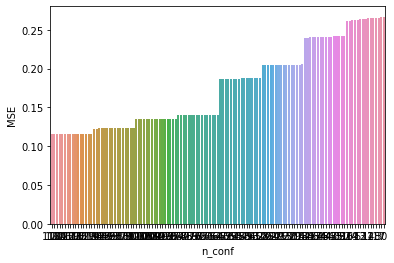

In [ ]:
##############################################
#APPEL DE FONCTION 'final_score_computer'  
#############################################

#Passer les paramètres
model=LinearRegression()
cols_X=['stem_tag','stem_year_status','stem_genres','sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1']
col_y=['rating']
train_df=train_df_MERGE_T_I
test_df=test_df_MERGE_T_I

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

In [ ]:
list_indices=['0.114012','0.242721','0.116083']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","IMAGE ONLY","TEXT & IMAGE"],columns=['Best_MSE_LINEAR_REGRESSION'])
df_integral_TA.sort_values(by=['Best_MSE_LINEAR_REGRESSION'], inplace=True, ascending=True)
df_integral_TA

#### **C.4.2.TEXT_IMAGE INTEGRATED MODELING WITH SVR**

STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.257503
std      0.028440
min      0.101650
25%      0.258450
50%      0.263457
75%      0.268648
max      0.281475


,Configurations,MSE,Labels,n_conf
111,config_111,0.101650,"[stem_year_status, stem_tag, stem_genres]",111
79,config_79,0.109952,"[stem_tag, stem_genres]",79
95,config_95,0.131557,"[stem_year_status, stem_tag]",95
63,config_63,0.133377,[stem_tag],63
47,config_47,0.182751,"[stem_year_status, stem_genres]",47
...,...,...,...,...
0,config_0,0.280071,[brightnessframe1],0
8,config_8,0.280184,"[sharpnessframe1, brightnessframe1]",8
7,config_7,0.280762,[sharpnessframe1],7
12,config_12,0.280832,"[sharpnessframe1, brightnessframe1, contrastframe1]",12


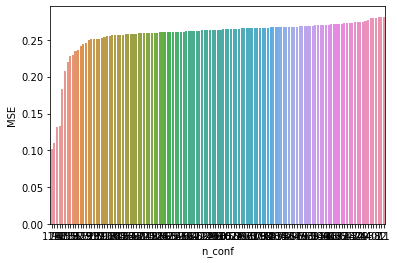

In [ ]:
#Passer les paramètres
model=SVR(kernel='rbf')
cols_X=['stem_tag','stem_year_status','stem_genres','sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1']
col_y=['rating']
train_df=train_df_MERGE_T_I
test_df=test_df_MERGE_T_I

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

In [ ]:
list_indices=['0.099036','0.252232','0.101650']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","IMAGE ONLY","TEXT & IMAGE"],columns=['Best_MSE_SVR_BOOST'])
df_integral_TA.sort_values(by=['Best_MSE_SVR_BOOST'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_SVR_BOOST
TEXT ONLY,0.099036
TEXT & IMAGE,0.101650
IMAGE ONLY,0.252232


#### **C.4.3.TEXT_IMAGE INTEGRATED MODELING WITH XGBoost**

STATISTICS OF MSE INDICATOR AND OUTPUT:
              MSE
count  127.000000
mean     0.173771
std      0.054946
min      0.106655
25%      0.126472
50%      0.145047
75%      0.204054
max      0.273847


,Configurations,MSE,Labels,n_conf
126,config_126,0.106655,"[sharpnessframe1, stem_year_status, stem_genres, brightnessframe1, stem_tag, contrastframe1, saturationframe1]",126
117,config_117,0.107422,"[stem_year_status, stem_genres, stem_tag, contrastframe1, saturationframe1]",117
125,config_125,0.107564,"[sharpnessframe1, stem_year_status, stem_genres, stem_tag, contrastframe1, saturationframe1]",125
123,config_123,0.107734,"[sharpnessframe1, stem_year_status, stem_genres, stem_tag, contrastframe1]",123
112,config_112,0.107769,"[stem_year_status, brightnessframe1, stem_tag, stem_genres]",112
...,...,...,...,...
11,config_11,0.268631,"[sharpnessframe1, contrastframe1]",11
3,config_3,0.269928,[contrastframe1],3
0,config_0,0.270749,[brightnessframe1],0
8,config_8,0.271632,"[sharpnessframe1, brightnessframe1]",8


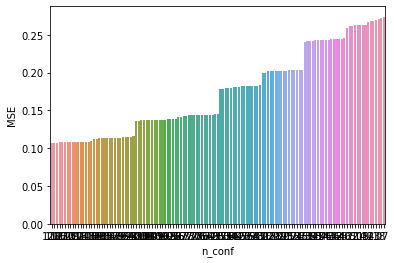

In [ ]:
model=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
cols_X=['stem_tag','stem_year_status','stem_genres','sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1']
col_y=['rating']
train_df=train_df_MERGE_T_I
test_df=test_df_MERGE_T_I

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

In [ ]:
# Dataframe : uniquement pour visusalisation multi-modal
list_indices=['0.109689','0.238604','0.106655']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","IMAGE ONLY","TEXT & IMAGE"],columns=['Best_MSE_XG_BOOST'])
df_integral_TA.sort_values(by=['Best_MSE_XG_BOOST'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_XG_BOOST
TEXT & IMAGE,0.106655
TEXT ONLY,0.109689
IMAGE ONLY,0.238604


# **D.EARLY INTEGRATION TEXT IMAGE AUDIO**

## **D.1.EARLY ALL MODALITIES INTEGRATION_MERGE ALL**

In [ ]:
df_MERGE_T_I_A = pd.merge(df_MERGE_T_I, df_audio, how='inner')
print("shape de merged dataframe :",df_MERGE_T_I.shape)
df_MERGE_T_I_A.head(3)

shape de merged dataframe : (6120, 10)


,movieId,rating,stem_tag,stem_genres,stem_plot,stem_year_status,sharpnessframe1,contrastframe1,saturationframe1,brightnessframe1,duree,rolloff,mfcc1,mfcc3
0,3,3.151040,old peopl actual funni sequel fever grun run m...,comedi romanc,john max resolv save belov bait shop turn ital...,old,27.937122,26.544125,50.690629,48.503366,111.920250,6852.587933,-228.152084,-28.875706
1,7,3.366484,greg kinnear romanc remadea sabrina 1995 remak...,comedi romanc,ugli duckl undergon remark chang still harbor ...,old,47.662478,45.824033,80.982509,49.766192,169.482500,5404.350321,-265.355255,-27.417568
2,11,3.667713,presid presid us presid white hous girli movi ...,comedi drama romanc,widow u presid run reelect environment lobbyis...,old,2.198145,0.679535,254.946784,2.148668,169.366375,6637.672909,-211.894577,-31.849499


In [ ]:
df_MERGE_T_I_A.shape

(5416, 14)

## **D.2.EARLY ALL MODALITIES INTEGRATION_SPLIT TRAIN TEST**

In [ ]:
#####################################################
# TRain Test split dataframe df_MERGE_T_A
#####################################################
# Ne pas changer pour garantir qu'on utilise tous les mêmes ensembles (train et test)
train_df_MERGE_T_I_A = df_MERGE_T_I_A.sample(frac=0.90, random_state=17)
train_df_MERGE_T_I_A = df_MERGE_T_I_A[df_MERGE_T_I_A['movieId'].isin(train_df_MERGE_T_I_A['movieId'])]
print("La taille de la collection d'entraînement est de",len(train_df_MERGE_T_I_A),"films")
test_df_MERGE_T_I_A = df_MERGE_T_I_A[~df_MERGE_T_I_A['movieId'].isin(train_df_MERGE_T_I_A['movieId'])]
print("La taille de la collection de test est de",len(test_df_MERGE_T_I_A),"films")

La taille de la collection d'entraînement est de 4874 films
La taille de la collection de test est de 542 films


## **D.3.EARLY ALL MODALITIES_MSE COMPUTATIONS**

### **D.3.1.MODELING ALL MODALITIES LINEAR REGRESSION**

STATISTICS OF MSE INDICATOR AND OUTPUT:
               MSE
count  2047.000000
mean      0.169521
std       0.054154
min       0.111407
25%       0.119866
50%       0.129241
75%       0.204403
max       0.267654


,Configurations,MSE,Labels,n_conf
2043,config_2043,0.111407,"[mfcc1, saturationframe1, brightnessframe1, mfcc3, stem_genres, contrastframe1, stem_year_status, sharpnessframe1, stem_tag]",2043
1947,config_1947,0.111443,"[mfcc1, mfcc3, sharpnessframe1, stem_genres, stem_year_status, brightnessframe1, stem_tag]",1947
2027,config_2027,0.111449,"[mfcc1, saturationframe1, mfcc3, stem_genres, contrastframe1, stem_year_status, sharpnessframe1, stem_tag]",2027
2045,config_2045,0.111450,"[mfcc1, duree, saturationframe1, brightnessframe1, mfcc3, stem_genres, contrastframe1, stem_year_status, sharpnessframe1, stem_tag]",2045
1979,config_1979,0.111452,"[mfcc1, saturationframe1, brightnessframe1, mfcc3, stem_genres, stem_year_status, sharpnessframe1, stem_tag]",1979
...,...,...,...,...
143,config_143,0.266813,"[brightnessframe1, sharpnessframe1]",143
15,config_15,0.267287,[brightnessframe1],15
191,config_191,0.267384,"[contrastframe1, sharpnessframe1]",191
63,config_63,0.267605,[contrastframe1],63


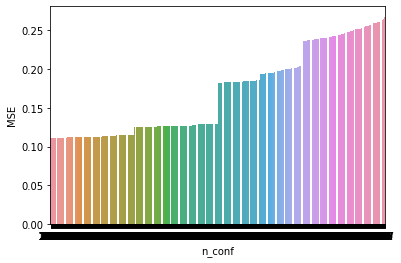

In [ ]:
##############################################
#APPEL DE FONCTION 'final_score_computer'  
#############################################

#Passer les paramètres
model=LinearRegression()
cols_X=['stem_tag','stem_year_status','stem_genres','sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1','mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_I_A
test_df=test_df_MERGE_T_I_A

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

### **D.3.2.MODELING ALL MODALITIES XG Boost**

STATISTICS OF MSE INDICATOR AND OUTPUT:
               MSE
count  2047.000000
mean      0.177158
std       0.052456
min       0.113001
25%       0.131168
50%       0.148806
75%       0.212802
max       0.278881


,Configurations,MSE,Labels,n_conf
1905,config_1905,0.113001,"[duree, saturationframe1, stem_genres, contrastframe1, stem_year_status, brightnessframe1, stem_tag]",1905
1926,config_1926,0.113741,"[rolloff, mfcc1, duree, stem_genres, stem_year_status, sharpnessframe1, stem_tag]",1926
1968,config_1968,0.113973,"[rolloff, saturationframe1, brightnessframe1, stem_genres, stem_year_status, sharpnessframe1, stem_tag]",1968
1961,config_1961,0.114095,"[duree, saturationframe1, mfcc3, stem_genres, stem_year_status, sharpnessframe1, stem_tag]",1961
1971,config_1971,0.114117,"[mfcc1, saturationframe1, brightnessframe1, stem_genres, stem_year_status, sharpnessframe1, stem_tag]",1971
...,...,...,...,...
143,config_143,0.275828,"[brightnessframe1, sharpnessframe1]",143
79,config_79,0.275868,"[contrastframe1, brightnessframe1]",79
223,config_223,0.276202,"[saturationframe1, contrastframe1, sharpnessframe1]",223
127,config_127,0.277992,[sharpnessframe1],127


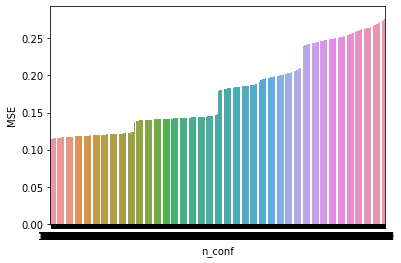

In [ ]:
##############################################
#APPEL DE FONCTION 'final_score_computer'  
#############################################

#Passer les paramètres
model=xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
cols_X=['stem_tag','stem_year_status','stem_genres','sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1','mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_I_A
test_df=test_df_MERGE_T_I_A

#Appeller la fonctionsimple : final_score_computer(model,cols_X,col_y,train_df,test_df)
#Appeller la fonction avec graphiques :
final_score_dframer(model,cols_X,col_y,train_df,test_df)

# **E.LATE INTEGRATION**

#### **Fonction generique**

In [ ]:
#adapter la foncton initiale pour qu'elle retourne la colonne prédite
def late_int_computer(model,cols_X,col_y,train_df,test_df):
    text_cols=['stem_tag','stem_genres','stem_plot','stem_year_status']
    from itertools import compress, product

    def combinations(items):
        return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )
        # alternative:                      ...in product([0,1], repeat=len(items)) 
        
    comb={}
    for i, item in enumerate(list(combinations(cols_X))[1:]):
      comb['config_'+str(i)]=list(item)
    comb

    score=[]
    for config in comb.keys():
      
      lst_train=[]
      lst_test=[]
      for col in comb[config]:
        if col in text_cols:
          vectorizer = TfidfVectorizer(min_df=50)
          vec_tr=vectorizer.fit_transform(train_df[col])
          lst_train.append(vec_tr.todense())
          lst_test.append(vectorizer.transform(test_df[col]).todense())
        else:
          
          lst_train.append(np.array(train_df[col].values).reshape(-1,1))          
          lst_test.append(np.array(test_df[col].values).reshape(-1,1))
      
      if len(lst_train)==1:         
        train=lst_train[0]
        test=lst_test[0]
      else:
        train=np.hstack(lst_train)
        test=np.hstack(lst_test)                 
      
      reg = model.fit(train,np.asarray(train_df[col_y]).ravel())

      pred = reg.predict(test)
      score.append((config, mean_squared_error(pred,test_df[col_y])))
    dict(score)
    return pred

#### **GENERATE PRED_TEXT**

In [ ]:

###############################################################################
# SET PAARAMETERS
###############################################################################
#predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
#Passer les paramètres
model=LinearRegression()
#cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
cols_X=['stem_tag','stem_year_status','stem_genres']
col_y=['rating']
train_df=train_df_MERGE_T_I_A
test_df=test_df_MERGE_T_I_A

###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
#returns array of ratings 
PRED_TEXT_LR=late_int_computer(model,cols_X,col_y,train_df,test_df)

In [ ]:
PRED_TEXT_LR.shape

(542,)

#### **GENERATE PRED_AUDIO**

In [ ]:
###############################################################################
# SET PAARAMETERS
###############################################################################
#predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
#Passer les paramètres
model=LinearRegression()
#cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
cols_X=['mfcc3','mfcc1','duree','rolloff']
col_y=['rating']
train_df=train_df_MERGE_T_I_A
test_df=test_df_MERGE_T_I_A

###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
#returns array of ratings 
PRED_AUDIO_LR=late_int_computer(model,cols_X,col_y,train_df,test_df)

In [ ]:
PRED_AUDIO_LR.shape

(542,)

#### **GENERATE PRED_IMAGE**

In [ ]:
###############################################################################
# SET PAARAMETERS
###############################################################################
#predictors=['stem_tag','stem_year_status','stem_genres','stem_plot']
#Passer les paramètres
model=LinearRegression()
#cols_X=['stem_tag','stem_year_status','stem_genres','mfcc3','mfcc1','duree','rolloff']
cols_X=['sharpnessframe1','contrastframe1',	'saturationframe1',	'brightnessframe1']
col_y=['rating']
train_df=train_df_MERGE_T_I_A
test_df=test_df_MERGE_T_I_A

###############################################################################
# RUN THE SCORE COMPUTER
###############################################################################
#returns array of ratings 
PRED_IMAGE_LR=late_int_computer(model,cols_X,col_y,train_df,test_df)

In [ ]:
PRED_IMAGE_LR.shape

(542,)

### **APPLICATION LATE INTEGRATION AUDIO & TEXT AVEC LINEAR REGRESSION**

In [ ]:
#Weight moyenne 
weight=0.5
pred_late_T_A=weight*(PRED_TEXT_LR+PRED_AUDIO_LR)

In [ ]:
#naive late integration 
mean_squared_error(pred_late_T_A,test_df_MERGE_T_I_A['rating'])

0.14248305042375692

In [ ]:
# Dataframe : uniquement pour visusalisation multi-modal
list_indices=['0.114012','0.217390','0.112231','0.234262']
df_integral_TA=pd.DataFrame(list_indices, index=[ "TEXT ONLY","AUDIO ONLY","TEXT & AUDIO_EARLY_INTEGRATION","TEXT & AUDIO_LATE_INTEGRATION_MEAN"],columns=['Best_MSE_LINEAR_REGRESSION'])
df_integral_TA.sort_values(by=['Best_MSE_LINEAR_REGRESSION'], inplace=True, ascending=True)
df_integral_TA

,Best_MSE_LINEAR_REGRESSION
TEXT & AUDIO_EARLY_INTEGRATION,0.112231
TEXT ONLY,0.114012
AUDIO ONLY,0.217390
TEXT & AUDIO_LATE_INTEGRATION_MEAN,0.234262


#### **Boost Late integration**

In [ ]:
#Booster les coefficients 

weight_text=1
weight_audio=0

Liste=[]
for i in range(0,10):
  pred_late_T_A=weight_text*PRED_TEXT_LR+weight_audio*PRED_AUDIO_LR
  mse=mean_squared_error(pred_late_T_A,test_df_MERGE_T_I_A['rating'])
  Liste.append([weight_text,weight_audio,mse])
  weight_text-=0.1
  weight_audio+=0.1



In [ ]:
pd.DataFrame(Liste,columns=['weight_text','weight_audio','mse'])

,weight_text,weight_audio,mse
0,1.0,0.0,0.111985
1,0.9,0.1,0.112180
2,0.8,0.2,0.115327
3,0.7,0.3,0.121427
4,0.6,0.4,0.130479
5,0.5,0.5,0.142483
6,0.4,0.6,0.157439
7,0.3,0.7,0.175348
8,0.2,0.8,0.196209
9,0.1,0.9,0.220022


### **APPLICATION LATE INTEGRATION AUDIO & TEXT & IMAGE AVEC LINEAR REGRESSION**

In [ ]:
 weight=0.333333
 pred_late_T_A_I=weight*(PRED_TEXT_LR+PRED_AUDIO_LR+PRED_IMAGE_LR)
 mean_squared_error(pred_late_T_A_I,test_df_MERGE_T_I_A['rating'])

0.17127883097531207

#### **Boost Late integration**

In [ ]:

weight_text = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,      0,0,0,0,0,0,0,0,0,0,                          0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,0.3333]
weight_audio = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,      0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,        0,0,0,0,0,0,0,0,0,0,0.3333]
weight_image = [0,0,0,0,0,0,0,0,0,0,                        0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0,        0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,0.3333]


Liste = []
for i in range(0,30):
    new_pred = weight_text[i] * PRED_TEXT_LR + weight_audio[i] * PRED_AUDIO_LR + weight_image[i] * PRED_IMAGE_LR
    mse=mean_squared_error(new_pred,test_df_MERGE_T_I_A['rating'])
    
    Liste.append([weight_text[i], weight_audio[i], weight_image[i], mse])

df = pd.DataFrame(sorted(Liste, reverse=True), columns=['poids_texte','poids_audio','poids_image','mse'])
df



,poids_texte,poids_audio,poids_image,mse
0,1.0,0.0,0.0,0.111985
1,0.9,0.1,0.0,0.112180
2,0.9,0.0,0.1,0.112558
3,0.8,0.2,0.0,0.115327
4,0.8,0.0,0.2,0.116373
5,0.7,0.3,0.0,0.121427
6,0.7,0.0,0.3,0.123432
7,0.6,0.4,0.0,0.130479
8,0.6,0.0,0.4,0.133734
9,0.5,0.5,0.0,0.142483
